# Portfolio Allocation & Optimization — Validation Notebook
    Data source: yfinance (Adj Close)
    Methods: Equal Weight, Minimum Variance, Maximum Sharpe
    Metrics: Annual return, volatility, Sharpe, max drawdown
    
**Disclaimer**: This project is for educational purposes only and does not constitute investment advice. The author is not responsible for any financial decisions made based on this project. Data may be delayed or inaccurate.


## 1) Import + Config

In [1]:
import sys
from pathlib import Path
project_root = Path().resolve().parent  # si notebook est dans /notebooks
sys.path.append(str(project_root))

In [2]:
#Import the Python libraries that we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import the functions that we have created in the src folder
from src.data import download_data
from src.analytics import calculate_return, calculate_mean_return, calculate_volatility, calculate_correlation
from src.optimization import equal_weight, min_variance_portfolio, max_sharpe_ratio
from src.risk import calculate_portfolio_vol, calculate_daily_returns, calculate_sharpe_ratio, calculate_drawdown

# Define the number of trading days in a year
TRADING_DAYS = 252

2026-02-08 19:02:12.576 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-02-08 19:02:12.584 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


## 2) Parameters

In [3]:
# Define the ticker of the stocks that we want to use
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL"]
# Define the time period in year
period_years = "1y"
# Define the type of return (simple/log)
return_type = "simple"   
# Define the risk-free rate
rf = 0.02
# Define the max weight for a single stock
max_weight = 0.40        

## 3) Download data and check data quality

In [4]:
#Download data
prices = download_data(tickers, period=period_years)
prices.head()

2026-02-08 19:02:20.063 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-02-08 19:02:20.067 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
[*********************100%***********************]  4 of 4 completed


,AAPL,MSFT,AMZN,GOOGL
Date,,,,
2025-02-07,226.605118,406.749481,229.149994,184.616959
2025-02-10,226.874191,409.201416,233.139999,185.742554
2025-02-11,231.827271,408.427124,232.759995,184.597046
2025-02-12,236.062775,406.044708,228.929993,182.893707
2025-02-13,240.706909,407.533752,230.369995,185.413834


In [5]:
#Check if we have any NA in our dataframe
nan_ratio = prices.isna().mean().sort_values(ascending=False)
nan_ratio

AAPL     0.0
MSFT     0.0
AMZN     0.0
GOOGL    0.0
dtype: float64

## 4) Returns and Checks

In [6]:
#Calculate returns
returns = calculate_return(prices, method=return_type)
returns.head()

,AAPL,MSFT,AMZN,GOOGL
Date,,,,
2025-02-10,0.001187,0.006028,0.017412,0.006097
2025-02-11,0.021832,-0.001892,-0.001630,-0.006167
2025-02-12,0.018270,-0.005833,-0.016455,-0.009227
2025-02-13,0.019673,0.003667,0.006290,0.013779
2025-02-14,0.012711,-0.005140,-0.007336,-0.004889


In [7]:
returns.describe()

,AAPL,MSFT,AMZN,GOOGL
count,250.000000,250.000000,250.000000,250.000000
mean,0.001018,0.000080,-0.000099,0.002425
std,0.020086,0.016494,0.022209,0.019455
min,-0.092456,-0.099931,-0.089791,-0.072597
25%,-0.006363,-0.007361,-0.011652,-0.008457
50%,0.000847,0.000771,0.000513,0.002057
75%,0.006517,0.006425,0.012246,0.012719
max,0.153289,0.101337,0.119770,0.096821


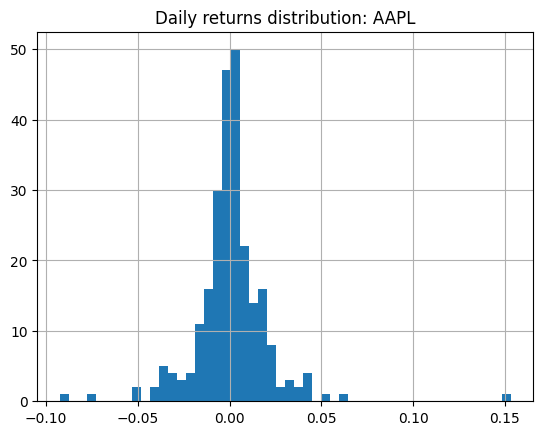

In [8]:
#Display the return distribution of one asset
returns[tickers[0]].hist(bins=50)
plt.title(f"Daily returns distribution: {tickers[0]}")
plt.show()

## 5) Compute the annual mean and covariance 

In [9]:
#Calculate mean and covariance
mu, cov = calculate_mean_return(returns)

print("mu shape:", mu.shape)
print("cov shape:", cov.shape)
mu, cov.head()

mu shape: (4,)
cov shape: (4, 4)


(AAPL     0.256500
 MSFT     0.020115
 AMZN    -0.024857
 GOOGL    0.611127
 dtype: float64,
            AAPL      MSFT      AMZN     GOOGL
 AAPL   0.101665  0.034838  0.060457  0.051274
 MSFT   0.034838  0.068558  0.049759  0.030393
 AMZN   0.060457  0.049759  0.124295  0.057669
 GOOGL  0.051274  0.030393  0.057669  0.095385)

In [10]:
#Check the annual sanity
vol_ann = returns.std() * np.sqrt(TRADING_DAYS)
summary = pd.DataFrame({
    "mu_ann": mu,
    "vol_ann": vol_ann
})
summary

,mu_ann,vol_ann
AAPL,0.256500,0.318850
MSFT,0.020115,0.261836
AMZN,-0.024857,0.352556
GOOGL,0.611127,0.308845


## 6) Check annual covariance

In [11]:
cov_np = cov.values
symmetry_error = np.max(np.abs(cov_np - cov_np.T))
print("Symmetry max error:", symmetry_error)

eigvals = np.linalg.eigvalsh(cov_np)
print("Min eigenvalue:", eigvals.min())
print("Number of negative eigenvalues:", np.sum(eigvals < -1e-10))

Symmetry max error: 0.0
Min eigenvalue: 0.03883986409314364
Number of negative eigenvalues: 0


## 7) Build portfolio

In [12]:
#Build equaly weight portfolio
w_eq = equal_weight(tickers)
w_eq

array([0.25, 0.25, 0.25, 0.25])

In [13]:
#Build min variance portfolio
w_minvar = min_variance_portfolio(cov_np, max_weight=max_weight)
w_minvar

array([0.2451412 , 0.4       , 0.03245509, 0.3224037 ])

In [14]:
#Build max sharpe portfolio
w_sharpe = max_sharpe_ratio(mu.values, cov_np, rf=rf, max_weight=max_weight)
w_sharpe

array([3.33333360e-01, 3.33333280e-01, 2.68940344e-10, 3.33333360e-01])

## 8) Check constains of each portfolio

In [15]:
def check_constraints(w, name="portfolio"):
    w = np.asarray(w)
    print(f"\n{name}")
    print("sum(weights):", w.sum())
    print("min(weight):", w.min())
    print("max(weight):", w.max())

check_constraints(w_eq, "Equal Weight")
check_constraints(w_minvar, "Min Variance")
check_constraints(w_sharpe, "Max Sharpe")


Equal Weight
sum(weights): 1.0
min(weight): 0.25
max(weight): 0.25

Min Variance
sum(weights): 1.0
min(weight): 0.032455094466147985
max(weight): 0.4

Max Sharpe
sum(weights): 1.0
min(weight): 2.6894034443761876e-10
max(weight): 0.33333335981714424


## 9) Calculate portfolio performance metrics

In [16]:
#Calculte the daily return of each portfolio
port_eq = calculate_daily_returns(returns, w_eq)
port_minvar = calculate_daily_returns(returns, w_minvar)
port_sharpe = calculate_daily_returns(returns, w_sharpe)

#Calculate the sharpe ratio of each portfolio to ensure that the MaxSharpe has the bigger sharpe ratio
print("EQ Sharpe:", calculate_sharpe_ratio(port_eq, rf=rf))
print("MinVar Sharpe:", calculate_sharpe_ratio(port_minvar, rf=rf))
print("MaxSharpe Sharpe:", calculate_sharpe_ratio(port_sharpe, rf=rf))

EQ Sharpe: 0.7995760115389393
MinVar Sharpe: 1.0698982731002757
MaxSharpe Sharpe: 1.1722223459582404


In [17]:
#Define a function to calculate the annual volatility
def ann_vol(s):
    return s.std() * np.sqrt(TRADING_DAYS)

#Calculate the annual volatility of each portfolio to ensure that the min variance has the lowest volatility
print("Vol EQ:", ann_vol(port_eq))
print("Vol MinVar:", ann_vol(port_minvar))
print("Vol MaxSharpe:", ann_vol(port_sharpe))

Vol EQ: 0.24478106308802222
Vol MinVar: 0.23100075999713648
Vol MaxSharpe: 0.23537658664188485


## 10) Calculate the cumulative performance

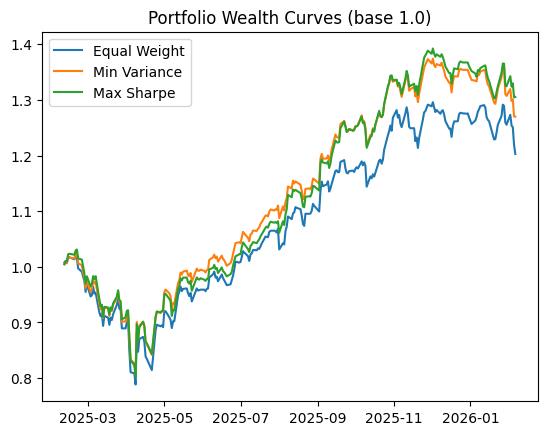

In [18]:
#Calculate the cumulative return of each portfolio
wealth_eq = (1 + port_eq).cumprod()
wealth_minvar = (1 + port_minvar).cumprod()
wealth_sharpe = (1 + port_sharpe).cumprod()

#Add in a plot each cumulative return to compare
plt.plot(wealth_eq, label="Equal Weight")
plt.plot(wealth_minvar, label="Min Variance")
plt.plot(wealth_sharpe, label="Max Sharpe")
plt.title("Portfolio Wealth Curves (base 1.0)")
plt.legend()
plt.show()

## 11) Calculate the max drowdown

In [19]:
dd_eq = calculate_drawdown(port_eq)
dd_minvar = calculate_drawdown(port_minvar)
dd_sharpe = calculate_drawdown(port_sharpe)

print("Max DD EQ:", dd_eq.min())
print("Max DD MinVar:", dd_minvar.min())
print("Max DD MaxSharpe:", dd_sharpe.min())

Max DD EQ: -0.2262092136340937
Max DD MinVar: -0.21004450814936054
Max DD MaxSharpe: -0.22137934902757955


## 12) Weights visualisation

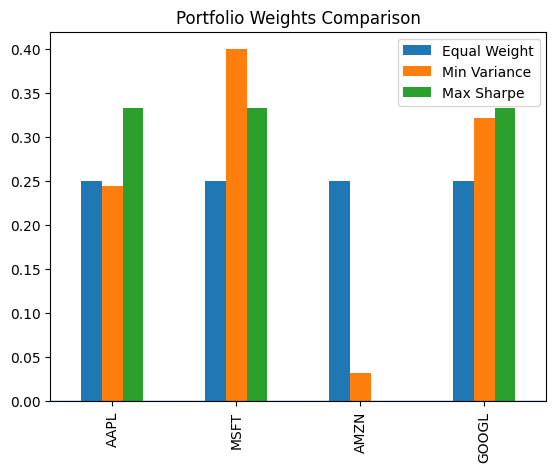

In [20]:
weights_df = pd.DataFrame({
    "Equal Weight": w_eq,
    "Min Variance": w_minvar,
    "Max Sharpe": w_sharpe
}, index=tickers)

weights_df.plot(kind="bar")
plt.title("Portfolio Weights Comparison")
plt.axhline(0, linewidth=1)
plt.show()